In [ ]:
# https://www.kaggle.com/code/sudalairajkumar/simple-exploration-notebook-instacart

In [ ]:
# Objective:
# The goal of the competition is to predict which products will be in a user's next order. The dataset is anonymized and contains a sample of over 3 million grocery orders from more than 200,000 Instacart users.
# For each user, 4 and 100 of their orders are given, with the sequence of products purchased in each order    

## 1. Import Libraries

In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

pd.options.mode.chained_assignment = None  # default='warn'

In [5]:
order_products_train_df = pd.read_csv("E:/Kaggle_Practice/Instacart_Market_Basket_Analysis/order_products__train.csv")
order_products_prior_df = pd.read_csv("E:/Kaggle_Practice/Instacart_Market_Basket_Analysis/order_products__prior.csv")
orders_df = pd.read_csv("E:/Kaggle_Practice/Instacart_Market_Basket_Analysis/orders.csv")
products_df = pd.read_csv("E:/Kaggle_Practice/Instacart_Market_Basket_Analysis/products.csv")
aisles_df = pd.read_csv("E:/Kaggle_Practice/Instacart_Market_Basket_Analysis/aisles.csv")
departments_df = pd.read_csv("E:/Kaggle_Practice/Instacart_Market_Basket_Analysis/departments.csv")

In [4]:
orders_df.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [5]:
order_products_train_df.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [7]:
order_products_prior_df.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


#### reorder = 1 : yes, 0 : no

In [8]:
products_df.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [9]:
aisles_df.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [10]:
departments_df.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [13]:
products_df.groupby('department_id')['aisle_id'].value_counts(ascending=False)

department_id  aisle_id
1              37          1091
               38           880
               129          386
               116          361
               79           335
                           ... 
20             67           327
               13           317
               14           159
               1            146
21             100         1258
Name: aisle_id, Length: 134, dtype: int64

In [14]:
departments_df.nunique()

department_id    21
department       21
dtype: int64

In [15]:
aisles_df.nunique()

aisle_id    134
aisle       134
dtype: int64

- #### As we could see, orders.csv has all the information about the given order id like the user who has purchased the order, when was it purchased, days since prior order and so on.<br/>
- #### The columns present in order_products_train and order_products_prior are same. Then what is the difference between these files.?- - #### As mentioned earlier, in this dataset, 4 to 100 orders of a customer are given (we will look at this later) and we need to predict the products that will be re-ordered. So the last order of the user has been taken out and divided into train and test sets. All the prior order informations of the customer are present in order_products_prior file. We can also note that there is a column in orders.csv file called eval_set which tells us as to which of the three datasets (prior, train or test) the given row goes to.<br/><br/>Order_products*csv file has more detailed information about the products that been bought in the given order along with the re-ordered status.

#### Let us first get the count of rows in each of the three sets

C:\Users\katenam\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


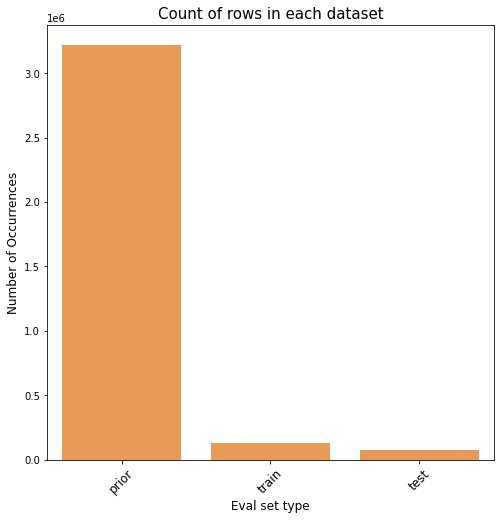

In [6]:
cnt_srs = orders_df.eval_set.value_counts()

plt.figure(figsize=(8,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[1])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Eval set type', fontsize=12)
plt.title('Count of rows in each dataset', fontsize=15)
plt.xticks(rotation=45,fontsize=12)
plt.show()

In [7]:
def get_unique_count(x):
    return len(np.unique(x))

cnt_srs = orders_df.groupby("eval_set")["user_id"].aggregate(get_unique_count)
cnt_srs

eval_set
prior    206209
test      75000
train    131209
Name: user_id, dtype: int64

#### So there are 206,209 customers in total. <br /><br /> Out of which, the last purchase of 131,209 customers are given as train set and we need to predict for the rest 75,000 customers.<br/><br/>Now let us validate the claim that 4 to 100 orders of a customer are given.

C:\Users\katenam\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


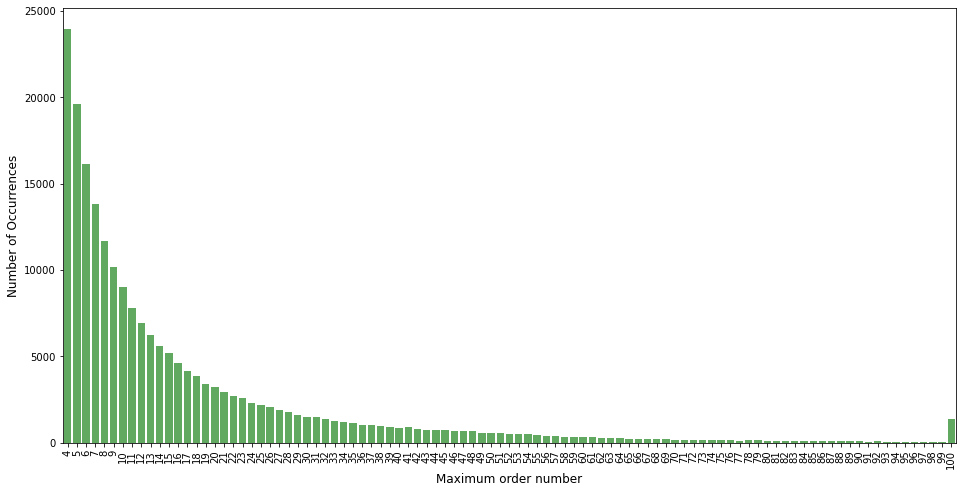

In [8]:
cnt_srs = orders_df.groupby("user_id")["order_number"].aggregate(np.max).reset_index()
cnt_srs = cnt_srs.order_number.value_counts()

plt.figure(figsize=(16,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[2])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Maximum order number', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

#### So there are no orders less than 4 and is max capped at 100 as given in the data page.<br/><br/>Now let us see how the ordering habit changes with day of week.

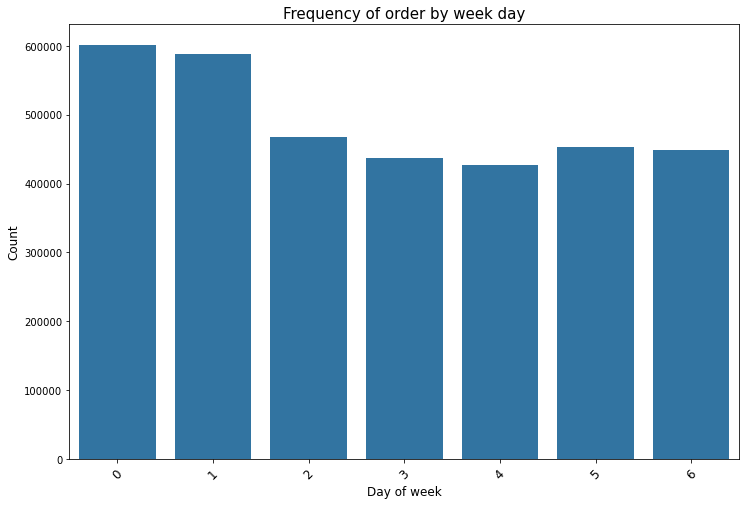

In [11]:
plt.figure(figsize=(12,8))
sns.countplot(x="order_dow", data=orders_df, color=color[0])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Day of week', fontsize=12)
plt.xticks(rotation=45,fontsize=12)
plt.title("Frequency of order by week day", fontsize=15)
plt.show()

#### Seems like 0 and 1 is Saturday and Sunday when the orders are high and low during Wednesday.<br/><br/>Now we shall see how the distribution is with respect to time of the day.

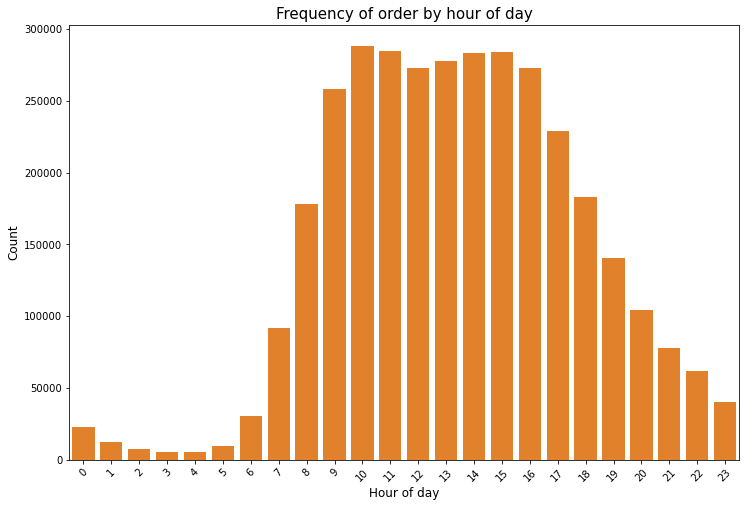

In [13]:
plt.figure(figsize=(12,8))
sns.countplot(x="order_hour_of_day", data=orders_df, color=color[1])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Hour of day', fontsize=12)
plt.xticks(rotation=45)
plt.title("Frequency of order by hour of day", fontsize=15)
plt.show()

#### So majority of the orders are made during day time.<br/><br/> Now let us combine the day of week and hour of day to see the distribution

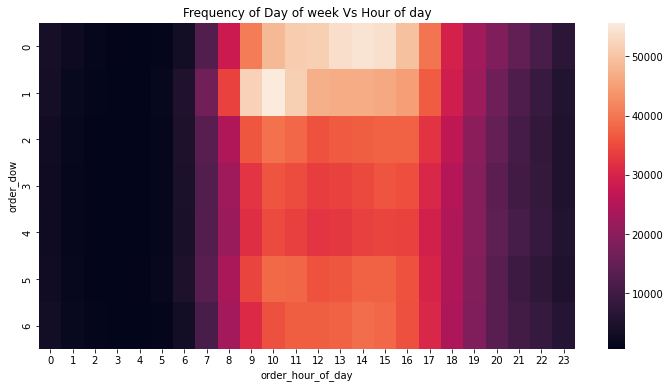

In [14]:
grouped_df = orders_df.groupby(["order_dow", "order_hour_of_day"])["order_number"].aggregate("count").reset_index()
grouped_df = grouped_df.pivot('order_dow', 'order_hour_of_day', 'order_number')

plt.figure(figsize=(12,6))
sns.heatmap(grouped_df)
plt.title("Frequency of Day of week Vs Hour of day")
plt.show()

#### Seems Satuday evenings and Sunday mornings are the prime time for orders.<br/><br/>Now let us check the time interval between the orders.

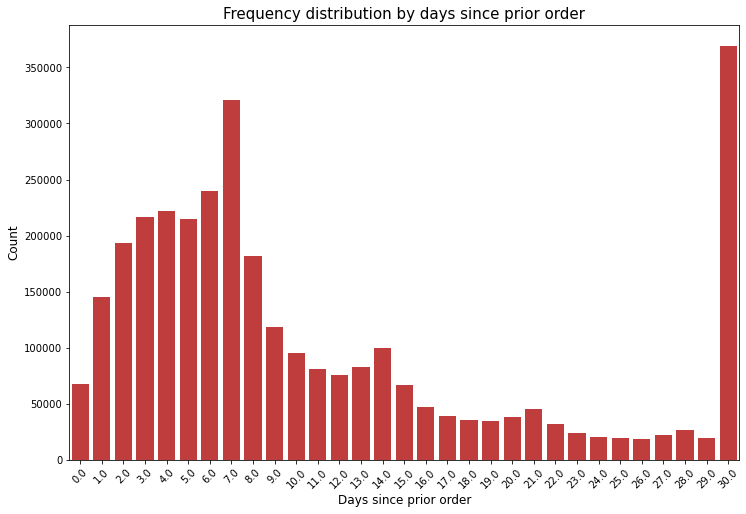

In [16]:
plt.figure(figsize=(12,8))
sns.countplot(x="days_since_prior_order", data=orders_df, color=color[3])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Days since prior order', fontsize=12)
plt.xticks(rotation=45)
plt.title("Frequency distribution by days since prior order", fontsize=15)
plt.show()

#### Looks like customers order once in every week (check the peak at 7 days) or once in a month (peak at 30 days). We could also see smaller peaks at 14, 21 and 28 days (weekly intervals).<br/><br/>Since our objective is to figure out the re-orders, let us check out the re-order percentage in prior set and train set.

In [17]:
# percentage of re-orders in prior set #
order_products_prior_df.reordered.sum() / order_products_prior_df.shape[0]

0.5896974667922161

In [18]:
order_products_prior_df.head() # reorder = 1:yes, 0:no

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [24]:
# percentage of re-orders in train set #
order_products_train_df.reordered.sum() / order_products_train_df.shape[0]

0.5985944127509629

#### On an average, about 59% of the products in an order are re-ordered products.

### No re-ordered products:
#### Now that we have seen 59% of the products are re-ordered, there will also be situations when none of the products are re-ordered. Let us check that now.

In [25]:
grouped_df = order_products_prior_df.groupby("order_id")["reordered"].aggregate("sum").reset_index()
grouped_df

,order_id,reordered
0,2,6
1,3,8
2,4,12
3,5,21
4,6,0
...,...,...
3214869,3421079,0
3214870,3421080,4
3214871,3421081,0
3214872,3421082,4


In [35]:
grouped_df["reordered"].iloc[grouped_df["reordered"]>1] = 1
grouped_df.reordered.value_counts() / grouped_df.shape[0]

1    0.879151
0    0.120849
Name: reordered, dtype: float64

In [36]:
grouped_df = order_products_train_df.groupby("order_id")["reordered"].aggregate("sum").reset_index()
grouped_df["reordered"].iloc[grouped_df["reordered"]>1] = 1
grouped_df.reordered.value_counts() / grouped_df.shape[0]

1    0.93444
0    0.06556
Name: reordered, dtype: float64

#### About 12% of the orders in prior set has no re-ordered items while in the train set it is 6.5%. <br/><br/>Now let us see the number of products bought in each order.

C:\Users\katenam\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


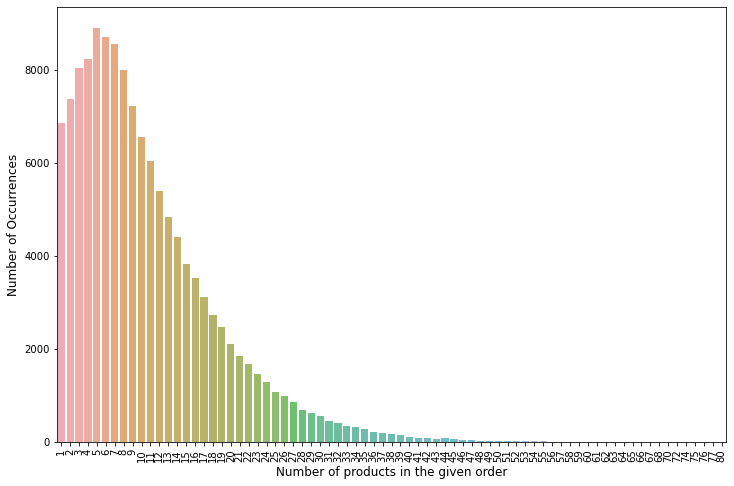

In [41]:
grouped_df = order_products_train_df.groupby("order_id")["add_to_cart_order"].aggregate("max").reset_index()
cnt_srs = grouped_df.add_to_cart_order.value_counts()

plt.figure(figsize=(12,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Number of products in the given order', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

#### x는 한번 쇼핑할때 바구니에 넣는 갯수를 의미하고 y는 예를들어 한번 쇼핑할때 바구니에 3개의 품목을 넣었던 빈도가 8000번 있었단 뜻<br/><br/>A right tailed distribution with the maximum value at 5.!<br/><br/>Before we explore the product details, let us look at the other three files as well.

In [42]:
products_df.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [43]:
aisles_df.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [44]:
departments_df.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol
